In [36]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from textblob import TextBlob
import re 

In [37]:
#Upload the dataset
df = pd.read_csv('amazon.csv')

In [38]:
print(df.info()) # Print the info about the columns and datatype


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           1465 non-null   object
 1   product_name         1465 non-null   object
 2   category             1465 non-null   object
 3   discounted_price     1465 non-null   object
 4   actual_price         1465 non-null   object
 5   discount_percentage  1465 non-null   object
 6   rating               1465 non-null   object
 7   rating_count         1463 non-null   object
 8   about_product        1465 non-null   object
 9   user_id              1465 non-null   object
 10  user_name            1465 non-null   object
 11  review_id            1465 non-null   object
 12  review_title         1465 non-null   object
 13  review_content       1465 non-null   object
 14  img_link             1465 non-null   object
 15  product_link         1465 non-null   object
dtypes: obj

In [39]:
# Categories distribution
category_distribution = df['category'].value_counts()
print(category_distribution)

Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|USBCables                                          233
Electronics|WearableTechnology|SmartWatches                                                                                 76
Electronics|Mobiles&Accessories|Smartphones&BasicMobiles|Smartphones                                                        68
Electronics|HomeTheater,TV&Video|Televisions|SmartTelevisions                                                               63
Electronics|Headphones,Earbuds&Accessories|Headphones|In-Ear                                                                52
                                                                                                                          ... 
Electronics|Cameras&Photography|Accessories|Batteries&Chargers|BatteryChargers                                               1
Computers&Accessories|NetworkingDevices|DataCards&Dongles                                                      

In [40]:
# Cleaning monetary symbols and column convertion to numerics 
def clean_and_convert_price(price_str):
    cleaned_price = re.sub(r'[^\d.]', '', price_str)  # Eliminate all except digits and dots 
    return pd.to_numeric(cleaned_price, errors='coerce')  # Convert to numerics 

df['discounted_price'] = df['discounted_price'].apply(clean_and_convert_price)
df['actual_price'] = df['actual_price'].apply(clean_and_convert_price)
df['discount_percentage'] = df['discount_percentage'].apply(clean_and_convert_price)

# Now, the columns would be in numeric format 
print(df[['discounted_price', 'actual_price', 'discount_percentage']].describe())

       discounted_price   actual_price  discount_percentage
count       1465.000000    1465.000000          1465.000000
mean        3125.310874    5444.990635            47.691468
std         6944.304394   10874.826864            21.635905
min           39.000000      39.000000             0.000000
25%          325.000000     800.000000            32.000000
50%          799.000000    1650.000000            50.000000
75%         1999.000000    4295.000000            63.000000
max        77990.000000  139900.000000            94.000000


In [41]:
# Set exchange rate INR to USD
exchange_rate = 0.014  # 1 INR = 0.014 USD

# Apply the exchange rate to price colums 
df['discounted_price_usd'] = df['discounted_price'] * exchange_rate
df['actual_price_usd'] = df['actual_price'] * exchange_rate

# Print statistics in USD 
print(df[['discounted_price_usd', 'actual_price_usd', 'discount_percentage']].describe())

       discounted_price_usd  actual_price_usd  discount_percentage
count           1465.000000       1465.000000          1465.000000
mean              43.754352         76.229869            47.691468
std               97.220262        152.247576            21.635905
min                0.546000          0.546000             0.000000
25%                4.550000         11.200000            32.000000
50%               11.186000         23.100000            50.000000
75%               27.986000         60.130000            63.000000
max             1091.860000       1958.600000            94.000000


Heatmap of Average Price of Top 5 by Categorie

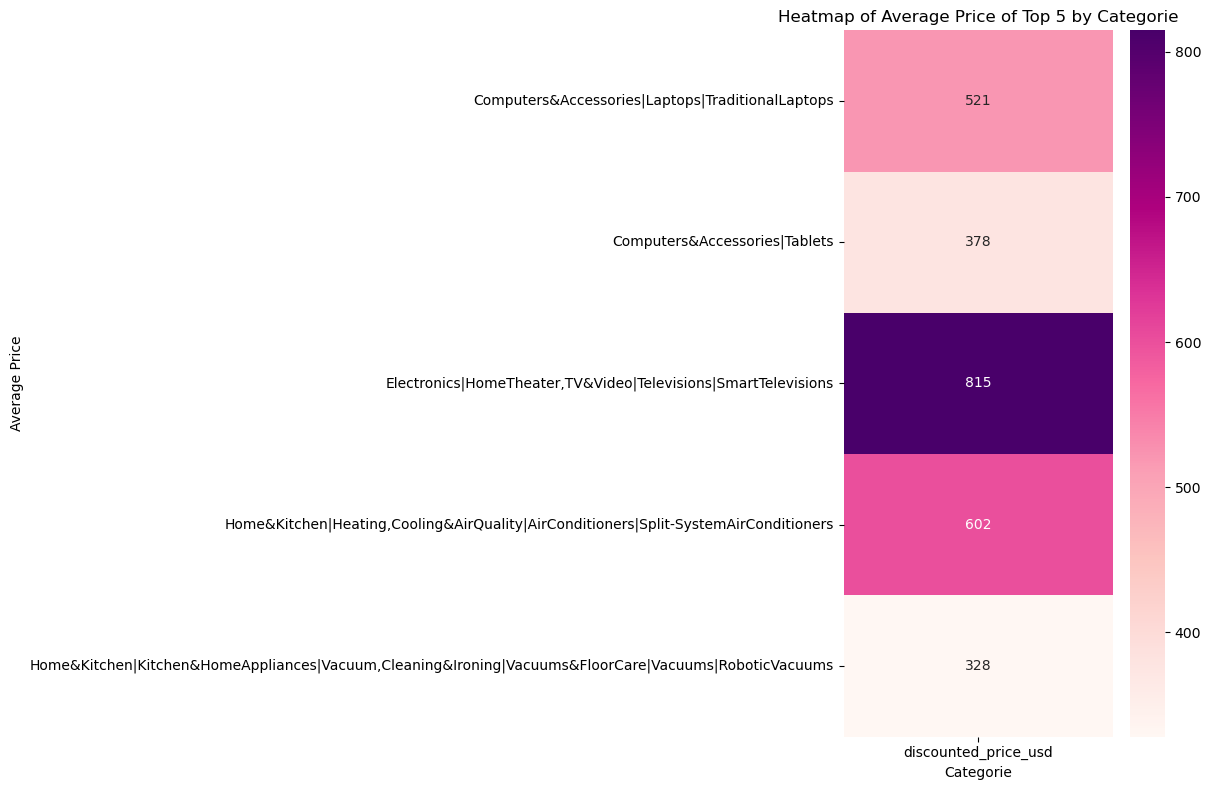

In [60]:
# Select the Top 5 Categories by Average 
top_categories = df.groupby('category')['discounted_price_usd'].mean().nlargest(5).index

# Select the Top 5 Products with discount of each selected categorie 
top_products_by_category = df[df['category'].isin(top_categories)].groupby('category').apply(lambda group: group.nlargest(5,'discounted_price_usd')).reset_index(drop=True)

# Create a pivot table for the average prices of top 5 products of each cateogorie
pivot_table = pd.pivot_table(top_products_by_category, values='discounted_price_usd', index='category', aggfunc=np.mean)

# Create the heatmap 
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='RdPu', annot=True, fmt=".0f")
plt.title('Heatmap of Average Price of Top 5 by Categorie')
plt.xlabel('Categorie')
plt.ylabel('Average Price')
plt.tight_layout()
plt.show()

Heatmap of Total Products By Categorie and Price Range (Top 5)

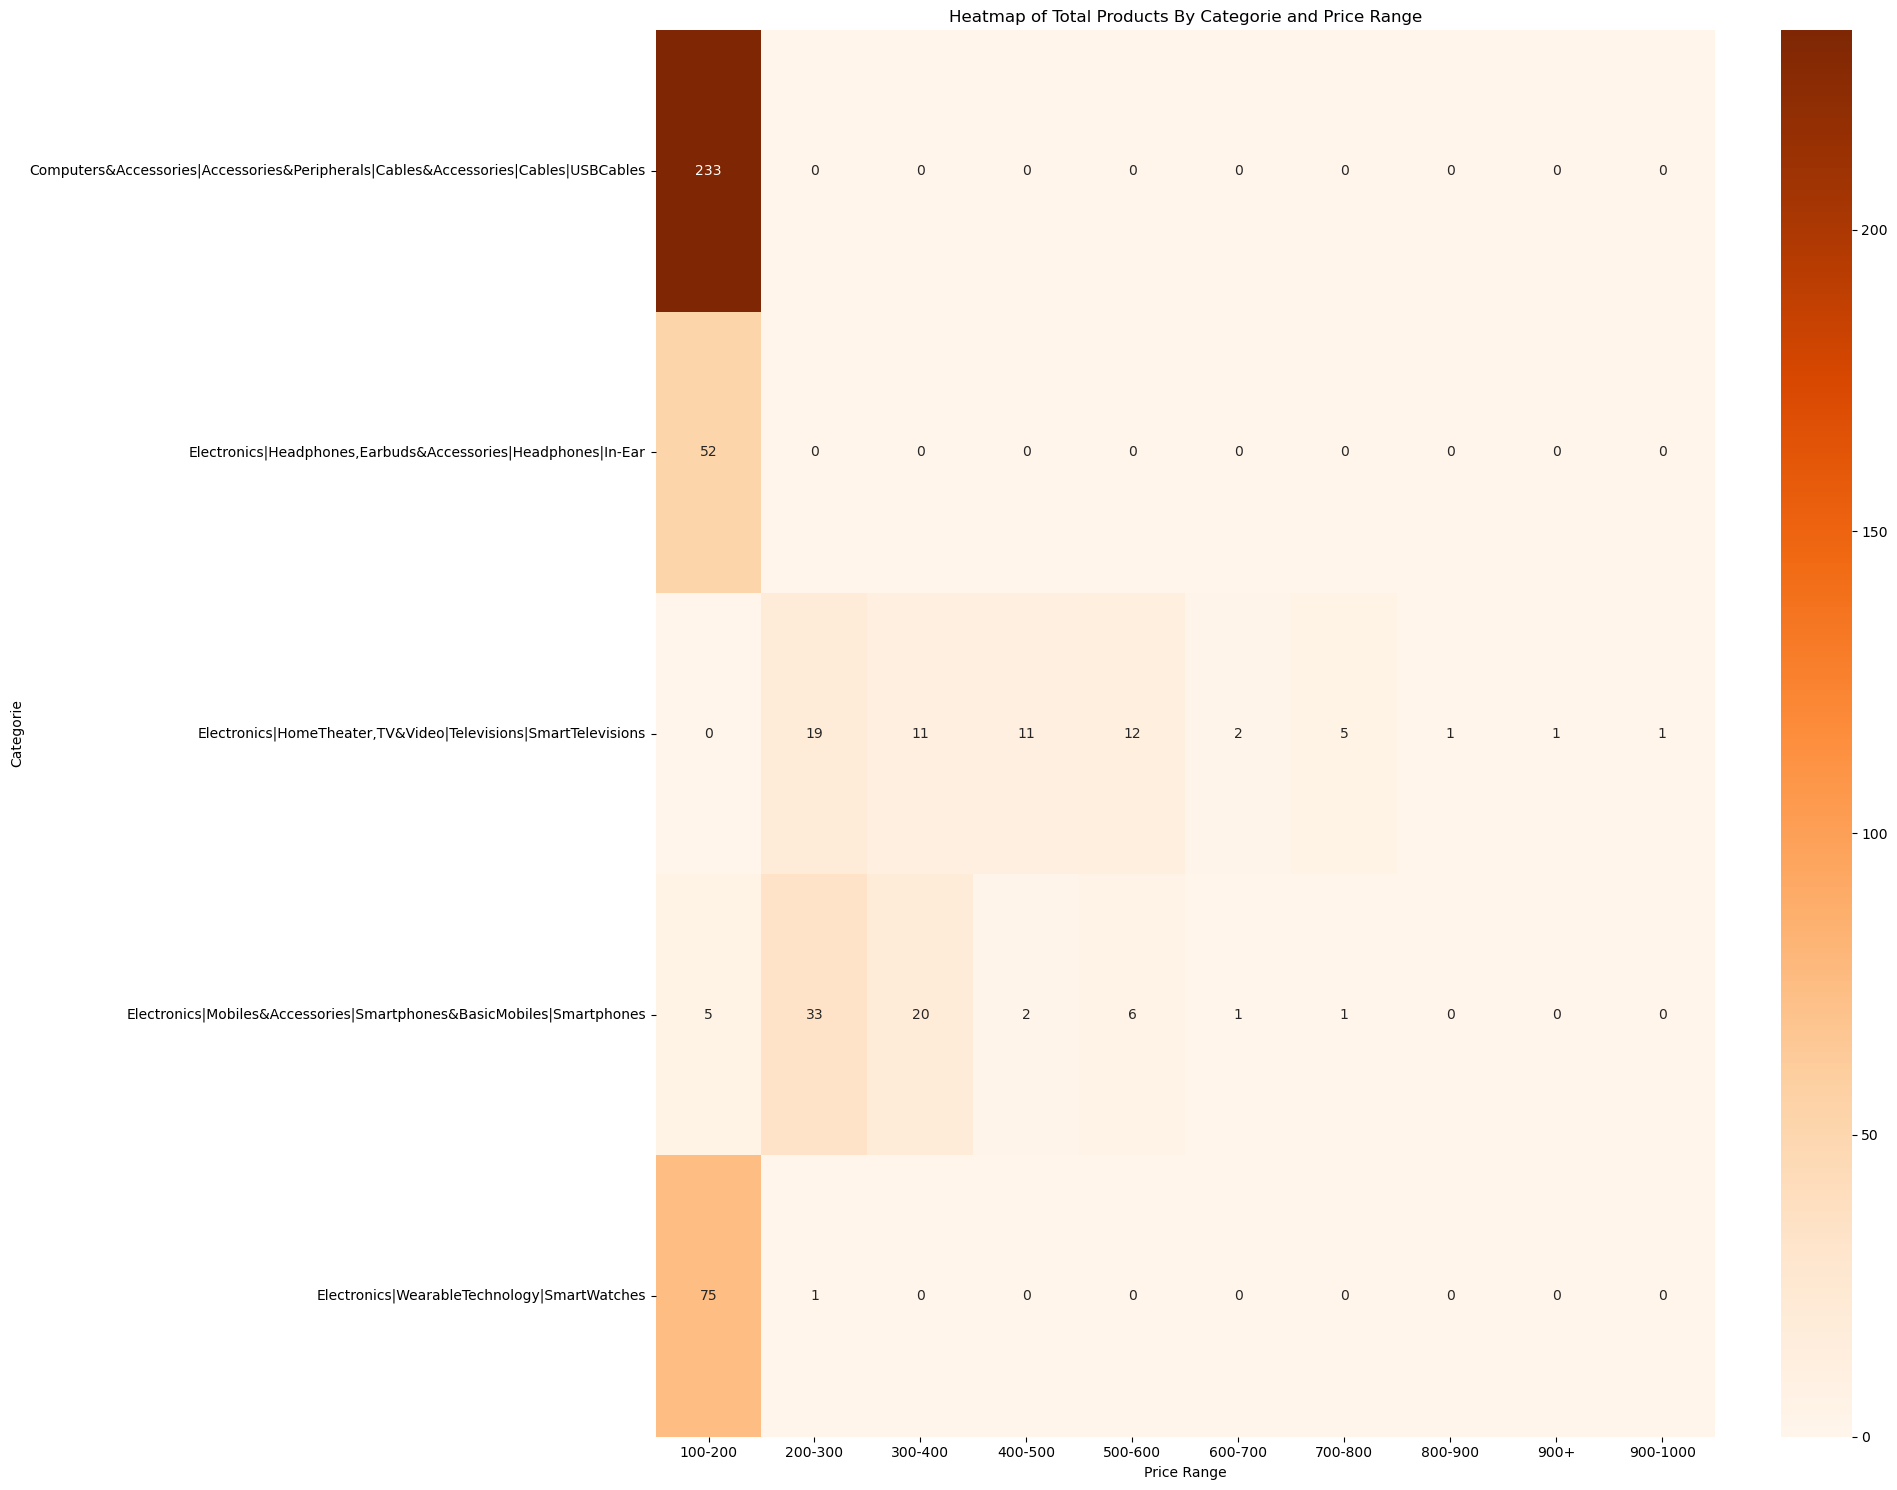

In [43]:
# Define the price range 
price_ranges = np.arange(0, 1000, 100)

# Function to assign each price to its corresponding range
def assign_price_range(price):
    for i, range_start in enumerate(price_ranges):
        if price <= range_start:
            return f"{range_start}-{range_start+100}"
    return f"{price_ranges[-1]}+"

# Apply the function to create a new column of price range 
df['price_range'] = df['discounted_price_usd'].apply(assign_price_range)

# Filter the more relevant categories
top_categories = df['category'].value_counts().nlargest(5).index
df_top_categories = df[df['category'].isin(top_categories)]

# Create a pivot table with the categories and price range 
pivot_table = pd.pivot_table(df_top_categories, values='product_id', index='category', columns='price_range', aggfunc='count', fill_value=0)

# Create the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(pivot_table, cmap= 'Oranges', annot=True, fmt='d')
plt.title('Heatmap of Total Products By Categorie and Price Range')
plt.xlabel('Price Range')
plt.ylabel('Categorie')
plt.tight_layout()
plt.show()

Top 5 of Poducts and Mean Price for Category

C:\Users\SESTO\AppData\Local\Temp\ipykernel_31328\3217679920.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


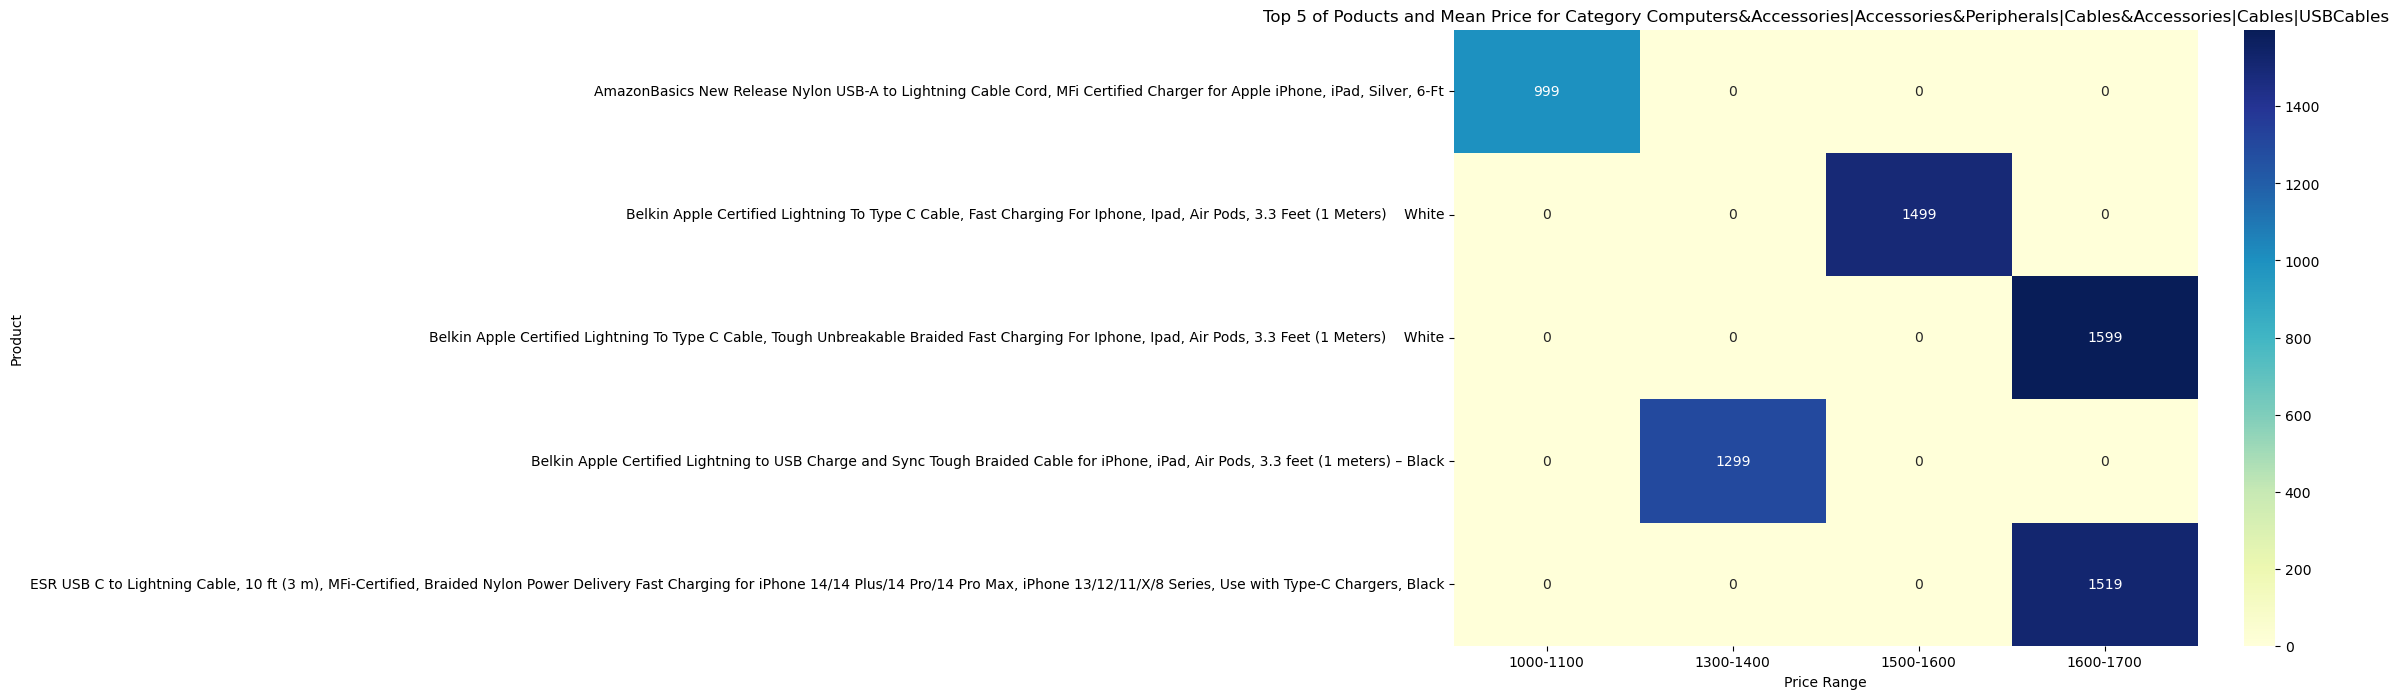

In [44]:
# Definie the Price Range 
price_ranges = np.arange(0, 8000, 100)  # Modifica estos valores según tus necesidades

# Function to assign each price to its corresponding range
def assign_price_range(price):
    for i, range_start in enumerate(price_ranges):
        if price <= range_start:
            return f"{range_start}-{range_start+100}"
    return f"{price_ranges[-1]}+"

# Apply the function to create a new column of price range 
df['price_range'] = df['discounted_price'].apply(assign_price_range)

# Filter the more relevant categories
top_category = df['category'].value_counts().nlargest(1).index[0]
df_top_category = df[df['category'] == top_category]

# Select the top 5 products with discount of the Top 1 Categorie 
top_products = df_top_category.nlargest(5, 'discounted_price')

# Create a pivot table with the price range and the top 5 products
pivot_table = pd.pivot_table(top_products, values='discounted_price', index='product_name', columns='price_range', aggfunc='mean', fill_value=0)

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt='.0f')
plt.title(f'Top 5 of Poducts and Mean Price for Category {top_category}')
plt.xlabel('Price Range')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

Create a histogram of Rating Distribution

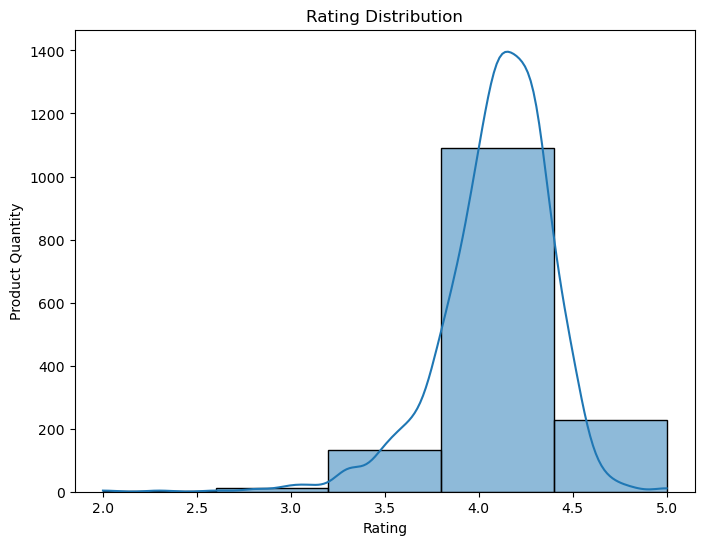

In [55]:
# Convert the columns 'rating' & 'rating_count' into numerics
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['rating_count'] = pd.to_numeric(df['rating_count'], errors='coerce')

# Create a histogramof ratings
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='rating', bins=5, kde=True)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Product Quantity')
plt.show()

Histogram of Rating Count Distribution of Amazon

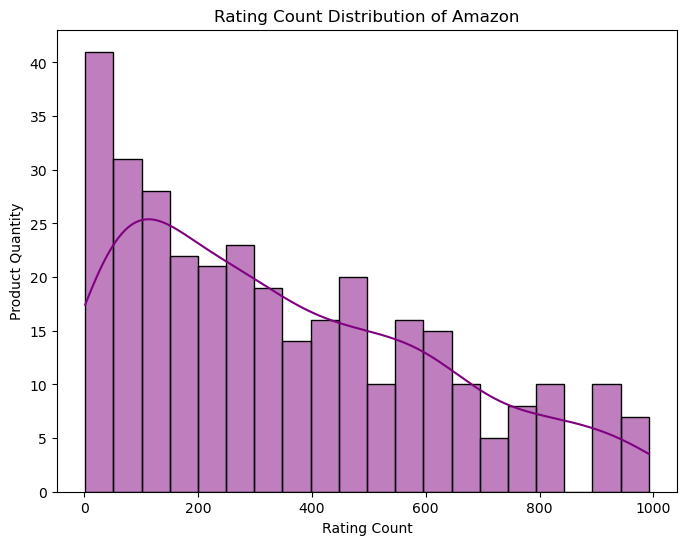

In [53]:
# Create a histogram of rating count of Amazon
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='rating_count', bins=20, kde=True, color='purple')
plt.title('Rating Count Distribution of Amazon')
plt.xlabel('Rating Count')
plt.ylabel('Product Quantity')
plt.show()

Scatterplot of Relation between Rating and Rating Count

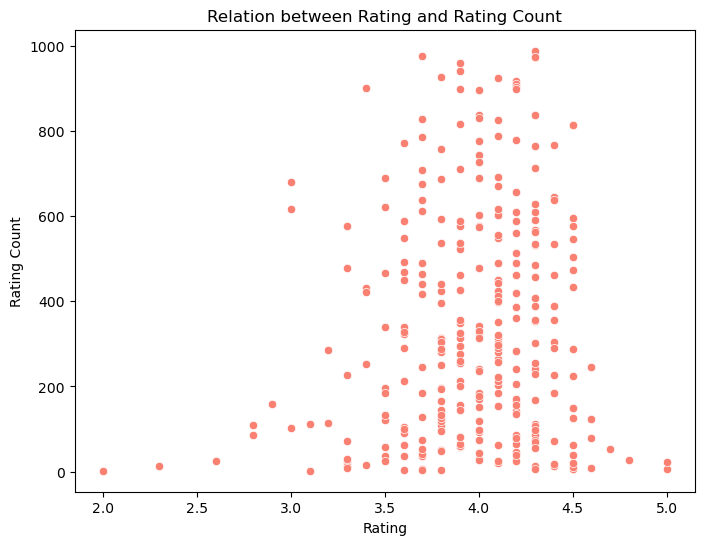

In [54]:
# Show relation between Rating and votes number in a scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='rating', y='rating_count', color='salmon')
plt.title('Relation between Rating and Rating Count')
plt.xlabel('Rating')
plt.ylabel('Rating Count')
plt.show()

Histogram of Review Count by User

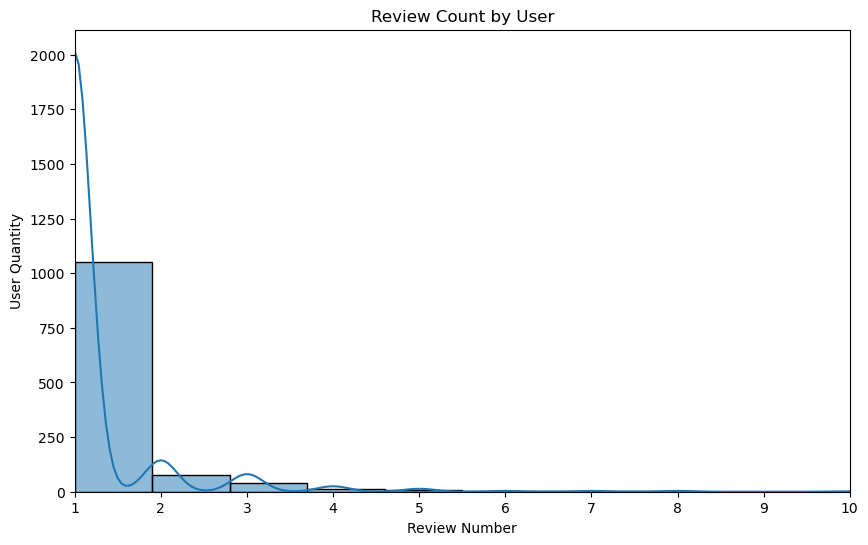

In [46]:
# Count the Reviews by user name
user_review_counts = df['user_name'].value_counts()

# Create a histogram of review count by user
plt.figure(figsize=(10, 6))
sns.histplot(data=user_review_counts, bins=user_review_counts.max(), kde=True)
plt.title('Review Count by User')
plt.xlabel('Review Number')
plt.ylabel('User Quantity')
plt.xlim(1, user_review_counts.max())
plt.xticks(range(1, user_review_counts.max() + 1))
plt.show()

Analysis of Review Sentiment Using NLP Techniques (TextBlob)

In [47]:
nltk.download('stopwords')
nltk.download('punkt')

# Function to clean and preprocess the text of review 
def preprocess_text(text):
    # Convert to lowercase 
    text = text.lower()
    
    # Generate tokens
    tokens = word_tokenize(text)
    
    # Eliminate stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    
    # bind tokens to get the processed text 
    preprocessed_text = ' '.join(stemmed_tokens)
    
    return preprocessed_text

# Apply the function of preprocess of all reviews 
df['preprocessed_review'] = df['review_content'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SESTO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SESTO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [48]:
# Function to analyze the sentiment
def analyze_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply the analysis of sentiment to preprocessed column 
df['sentiment'] = df['preprocessed_review'].apply(analyze_sentiment)

# Print the first rows of DataFrame with the relevant columns 
print(df[['review_content', 'preprocessed_review', 'sentiment']].head())

                                      review_content  \
0  Looks durable Charging is fine tooNo complains...   
1  I ordered this cable to connect my phone to An...   
2  Not quite durable and sturdy,https://m.media-a...   
3  Good product,long wire,Charges good,Nice,I bou...   
4  Bought this instead of original apple, does th...   

                                 preprocessed_review  sentiment  
0  look durabl charg fine toono complain charg re...   0.452778  
1  order cabl connect phone android auto car cabl...   0.315224  
2  quit durabl sturdi http work good http product...   0.633333  
3  good product long wire charg good nice bought ...   0.461111  
4  bought instead origin appl work 150r fast appl...   0.432469  


Getting the Products with ther Higher and lower Sentiment

In [49]:
# Group by product and calculate the average sentiment
sentiment_by_product = df.groupby('product_name')['sentiment'].mean()

# Show the productd with the higher and lower sentiment 
top_positive_products = sentiment_by_product.nlargest(10)
top_negative_products = sentiment_by_product.nsmallest(10)

print('Products with best Sentiment:')
print(top_positive_products)
print('\nProducts with worst Sentiment:')
print(top_negative_products)

Products with best Sentiment:
product_name
Khaitan ORFin Fan heater for Home and kitchen-K0 2215                                                                                                                                 0.850000
iBELL SEK15L Premium 1.5 Litre Stainless Steel Electric Kettle,1500W Auto Cut-Off Feature,Silver with Black                                                                           0.750000
Classmate Drawing Book - Unruled, 40 Pages, 210 mm x 297 mm - Pack Of 4                                                                                                               0.742857
Noise ColorFit Ultra Buzz Bluetooth Calling Smart Watch with 1.75" HD Display, 320x385 px Resolution, 100 Sports Modes, Stock Market Info Smartwatch for Men & Women (Olive Green)    0.740000
Preethi MGA-502 0.4-Litre Grind and Store Jar (White), stainless steel, Set of 1                                                                                                      0.740000
Te

Histogtram of Sentiment Distribution

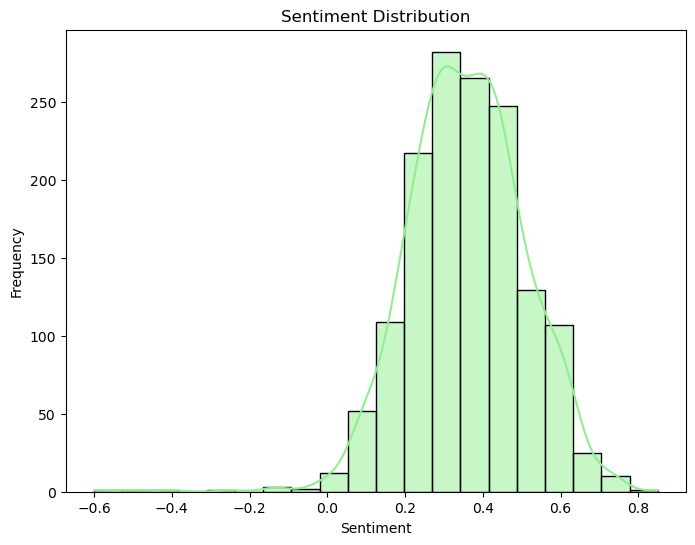

In [50]:
# Create a histogram of distribution of sentiment 
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='sentiment', bins=20, kde=True, color='lightgreen')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

Top 5 Categories with better Average Sentiment 

C:\Users\SESTO\AppData\Local\Temp\ipykernel_31328\723426986.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


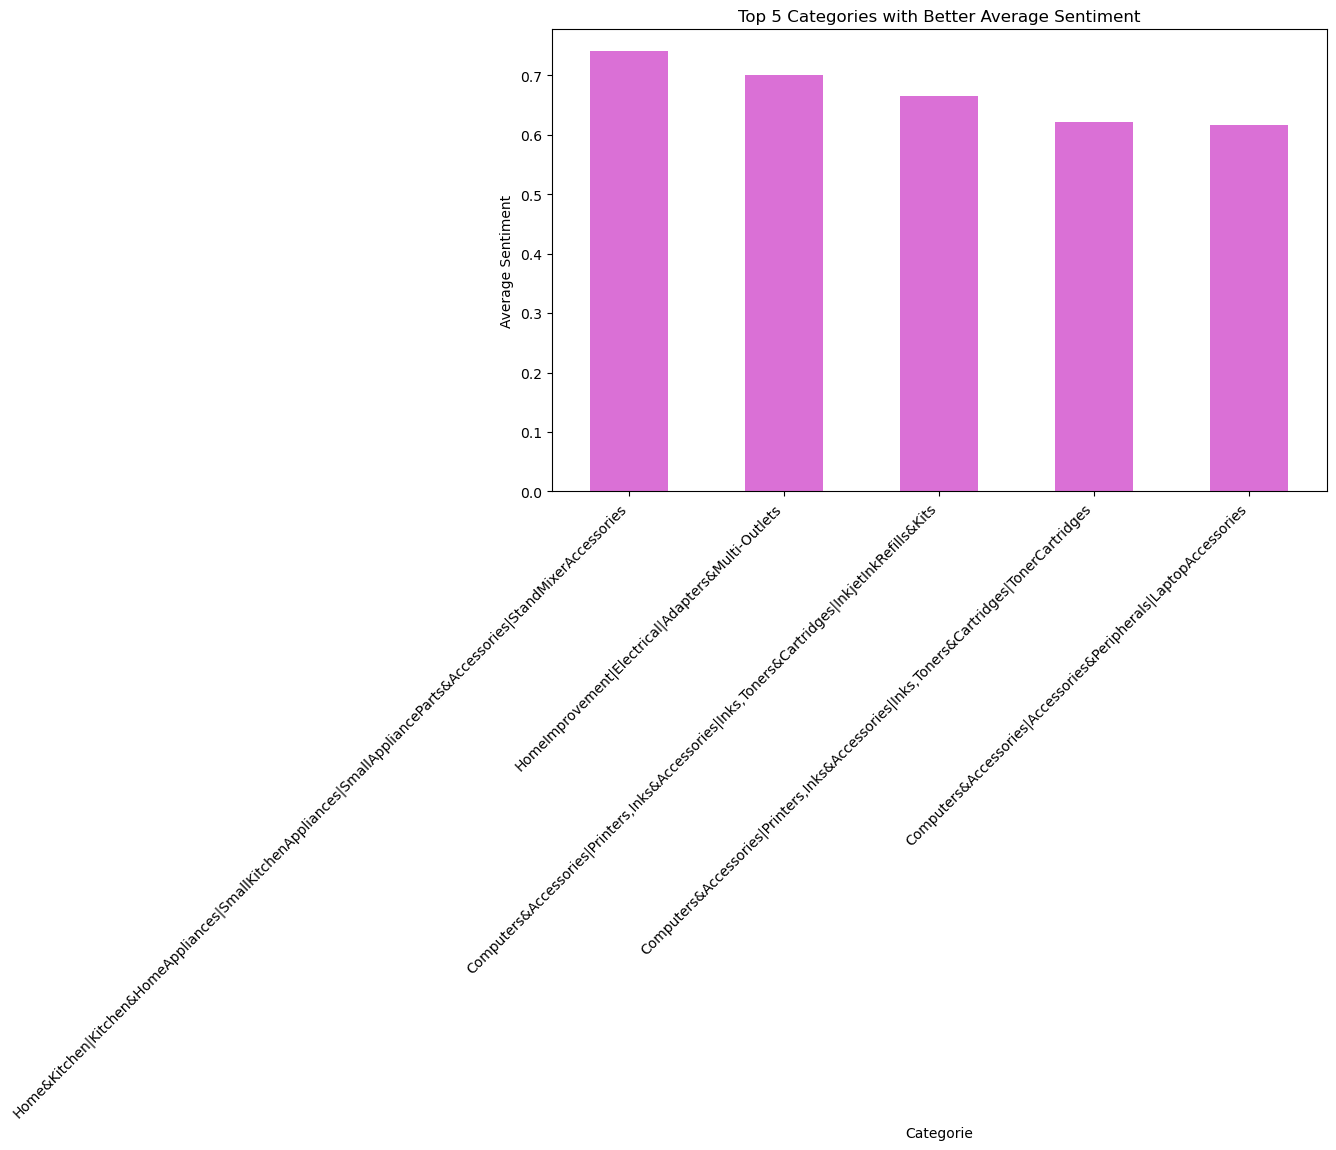

In [51]:
# Order the categories by descendent average sentiment and take the top 5  
top_sentiment_categories = sentiment_by_category.sort_values(ascending=False).head(5)

# Create a bar chart to visualize the results of top 5
top_sentiment_categories.plot(kind='bar', figsize=(10, 6), color='orchid')
plt.title('Top 5 Categories with Better Average Sentiment')
plt.xlabel('Categorie')
plt.ylabel('Average Sentiment')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Chart with Comparative of Average Sentiment by Categorie 

C:\Users\SESTO\AppData\Local\Temp\ipykernel_31328\166210534.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_categories = top_sentiment_categories.append(worst_sentiment_categories)


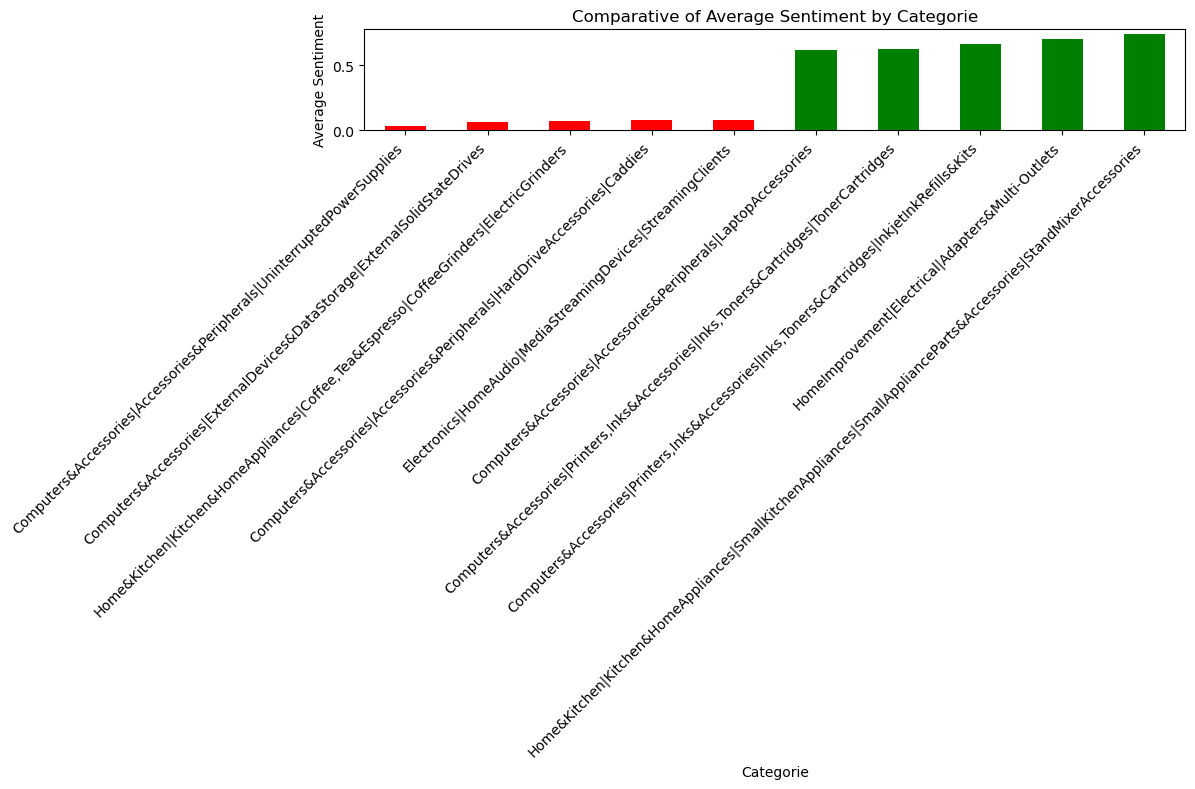

In [57]:
# Order the categories by ascending average sentiment and take the worst 5
worst_sentiment_categories = sentiment_by_category.sort_values(ascending=True).head(5)

# Combinate the two lists by categories to comparate 
combined_categories = top_sentiment_categories.append(worst_sentiment_categories)

# Personalize the colors 
colors = ['red' if cat in top_sentiment_categories else 'green' for cat in combined_categories.index]

# Create a bar char with the personalized colors
combined_categories.sort_values().plot(kind='bar', color=colors, figsize=(12, 8))
plt.title('Comparative of Average Sentiment by Categorie')
plt.xlabel('Categorie')
plt.ylabel('Average Sentiment')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()